In [55]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as F
from torchvision.models import inception_v3, Inception_V3_Weights

import os
import glob
from PIL import Image
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np

# From experiment 1

In [56]:
image_w = 1920
image_h = 1080
dummy_img = torch.zeros(1, 3, image_h, image_w).float()

In [57]:
class InceptionFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        model = inception_v3(weights=Inception_V3_Weights.DEFAULT, transform_input=True)
        self.feature_extractor = nn.Sequential(
            model.Conv2d_1a_3x3,
            model.Conv2d_2a_3x3,
            model.Conv2d_2b_3x3,
            model.maxpool1,
            model.Conv2d_3b_1x1,
            model.Conv2d_4a_3x3,
            model.maxpool2,
            model.Mixed_5b,
            model.Mixed_5c,
            model.Mixed_5d,
            model.Mixed_6a,
            model.Mixed_6b,
            model.Mixed_6c,
            model.Mixed_6d,
            model.Mixed_6e,
            model.Mixed_7a, 
            model.Mixed_7b, 
            model.Mixed_7c
        )
        
    def forward(self, x):
        return self.feature_extractor(x)
    
feature_extractor = InceptionFeatureExtractor()
feature_extractor.eval() 
out_dummy_img = feature_extractor(dummy_img)
print(f"Output shape: {out_dummy_img.shape}")
print(f"Number of channels: {out_dummy_img.shape[1]}")
print(f"Spatial dimensions: {out_dummy_img.shape[2]}x{out_dummy_img.shape[3]}")

Output shape: torch.Size([1, 2048, 32, 58])
Number of channels: 2048
Spatial dimensions: 32x58


In [58]:
def visualize_features(feature_extractor, image_dir = '../soccernet_data/tracking/train/SNMOT-060/img1'):
    
    if not os.path.exists(image_dir):
        print(f"Directory {image_dir} does not exist.")

    image_files = sorted(glob.glob(os.path.join(image_dir, '*.jpg')))
    sample_images = image_files[:3]

    image_net_mean = [0.485, 0.456, 0.406]
    image_net_std=[0.229, 0.224, 0.225]
    sample_images = image_files[:3]  
        
    transform = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=image_net_mean, std=image_net_std)
    ])

    for img_path in sample_images:

        img = Image.open(img_path).convert('RGB')
        img_w, img_h = img.size
        img_tensor = transform(img).unsqueeze(0)  

        with torch.no_grad():
            features = feature_extractor(img_tensor)

        print(f"Image: {os.path.basename(img_path)}")
        print(f"Original image dimensions: {img_w}x{img_h}")
        print(f"Feature map shape: {features.shape}")

        plt.figure(figsize=(10, 5.625))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        feature_map = features[0].sum(dim=0).cpu().numpy()
        plt.imshow(feature_map, cmap='viridis')
        plt.title(f"Feature Map (Sum of {features.shape[1]} channels)")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

In [59]:
feature_extractor = InceptionFeatureExtractor()
feature_extractor.eval() 
out_dummy_img = feature_extractor(dummy_img)
print(f"Output shape: {out_dummy_img.shape}")
print(f"Number of channels: {out_dummy_img.shape[1]}")
print(f"Spatial dimensions: {out_dummy_img.shape[2]}x{out_dummy_img.shape[3]}")
# visualize_features(feature_extractor)

Output shape: torch.Size([1, 2048, 32, 58])
Number of channels: 2048
Spatial dimensions: 32x58


# Experiment 2: Bounding box tests

## Testing anchor box centers for lowest resolution features (layer 7d)

In [60]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

feature_map_height = out_dummy_img.shape[2]
feature_map_width = out_dummy_img.shape[3]
original_height, original_width = dummy_img.shape[2], dummy_img.shape[3]
downsampling_factor_h = original_height / feature_map_height 
downsampling_factor_w = original_width / feature_map_width

scales = [8, 16, 32]
aspect_ratios = [0.5, 1.0, 2.0]

In [61]:
def generate_base_anchors(scales, aspect_ratios, downsampling_factor_h, downsampling_factor_w):
    ctr_y = downsampling_factor_h / 2.0
    ctr_x = downsampling_factor_w / 2.0
    num_anchors = len(scales) * len(aspect_ratios)
    base_anchors = np.zeros((num_anchors, 4), dtype=np.float32)

    index = 0
    for scale in scales:
        for ar in aspect_ratios:
            h = downsampling_factor_h * scale * np.sqrt(ar)
            w = downsampling_factor_w * scale * np.sqrt(1.0 / ar)
            base_anchors[index, 0] = ctr_y - h / 2.0
            base_anchors[index, 1] = ctr_x - w / 2.0
            base_anchors[index, 2] = ctr_y + h / 2.0
            base_anchors[index, 3] = ctr_x + w / 2.0
            
            index += 1
            
    return base_anchors



def generate_anchor_boxes(feature_map_size, base_anchors, downsampling_factor_h, downsampling_factor_w):
    height, width = feature_map_size
    shift_y = np.arange(0, height) * downsampling_factor_h
    shift_x = np.arange(0, width) * downsampling_factor_w
    shift_x, shift_y = np.meshgrid(shift_x, shift_y)
    
    shifts = np.vstack((
        shift_y.ravel(), shift_x.ravel(),
        shift_y.ravel(), shift_x.ravel()
    )).transpose()
    
    A = base_anchors.shape[0]  
    K = shifts.shape[0]  
    all_anchors = base_anchors.reshape((1, A, 4)) + shifts.reshape((K, 1, 4))
    all_anchors = all_anchors.reshape((K * A, 4))
    
    return all_anchors


def visualize_anchor_centers(image_tensor, feature_map_size, downsampling_factor_h, downsampling_factor_w):
    # With batch dimension
    if image_tensor.dim() == 4: 
      img_h, img_w = image_tensor.shape[2], image_tensor.shape[3]
      img_display = image_tensor.squeeze(0) # Remove batch dim for display
    # Without batch dimension
    elif image_tensor.dim() == 3:
      img_h, img_w = image_tensor.shape[1], image_tensor.shape[2]
      img_display = image_tensor
    

    aspect_ratio = img_w / img_h
    height, width = feature_map_size
    img = img_display.permute(1, 2, 0).cpu().numpy()
    img_min, img_max = img.min(), img.max()
    if img_max > img_min: 
        img = (img - img_min) / (img_max - img_min)

    fig_width = 10 
    fig_height = fig_width / aspect_ratio
    plt.figure(figsize=(fig_width, fig_height))

    ax = plt.gca()
    ax.imshow(img, extent=(0, img_w, img_h, 0))
    center_y = np.arange(0, height) * downsampling_factor_h + downsampling_factor_h / 2.0
    center_x = np.arange(0, width) * downsampling_factor_w + downsampling_factor_w / 2.0
    center_x, center_y = np.meshgrid(center_x, center_y)
    
    ax.scatter(center_x, center_y, c='b', s=10, alpha=0.6, marker='o') 
    ax.set_title(f'Anchor centers ({height}x{width}) mapped to image space')
    ax.set_xlim(0, img_w)
    ax.set_ylim(img_h, 0)
    ax.set_xlabel("Width (pixels)")
    ax.set_ylabel("Height (pixels)")
    ax.set_aspect('equal', adjustable='box')
    
    plt.tight_layout() 
    plt.show()

# anchor boxes: 16704
anchor box shape: (16704, 4)


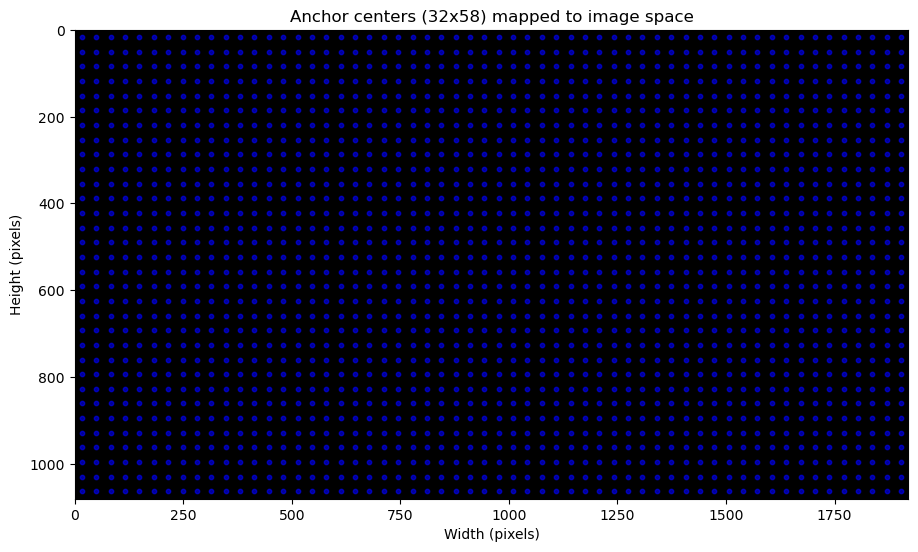

In [62]:
base_anchors = generate_base_anchors(scales, aspect_ratios, downsampling_factor_h, downsampling_factor_w)
anchors = generate_anchor_boxes(
    (feature_map_height, feature_map_width),
    base_anchors,
    downsampling_factor_h,
    downsampling_factor_w
)

print(f"# anchor boxes: {len(anchors)}")
print(f"anchor box shape: {anchors.shape}")
visualize_anchor_centers(dummy_img, (feature_map_height, feature_map_width), downsampling_factor_h, downsampling_factor_w)

## Testing anchor boxes for medium resolution features (layer 6e)

In [63]:
class InceptionFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        model = inception_v3(weights=Inception_V3_Weights.DEFAULT, transform_input=True)
        self.feature_extractor = nn.Sequential(
            model.Conv2d_1a_3x3,
            model.Conv2d_2a_3x3,
            model.Conv2d_2b_3x3,
            model.maxpool1,
            model.Conv2d_3b_1x1,
            model.Conv2d_4a_3x3,
            model.maxpool2,
            model.Mixed_5b,
            model.Mixed_5c,
            model.Mixed_5d,
            model.Mixed_6a,
            model.Mixed_6b,
            model.Mixed_6c,
            model.Mixed_6d,
            model.Mixed_6e,
            # model.Mixed_7a, 
            # model.Mixed_7b, 
            # model.Mixed_7c
        )
        
    def forward(self, x):
        return self.feature_extractor(x)
    


Output shape: torch.Size([1, 768, 65, 118])
Number of channels: 768
Spatial dimensions: 65x118
# anchor boxes: 69030
anchor box shape: (69030, 4)


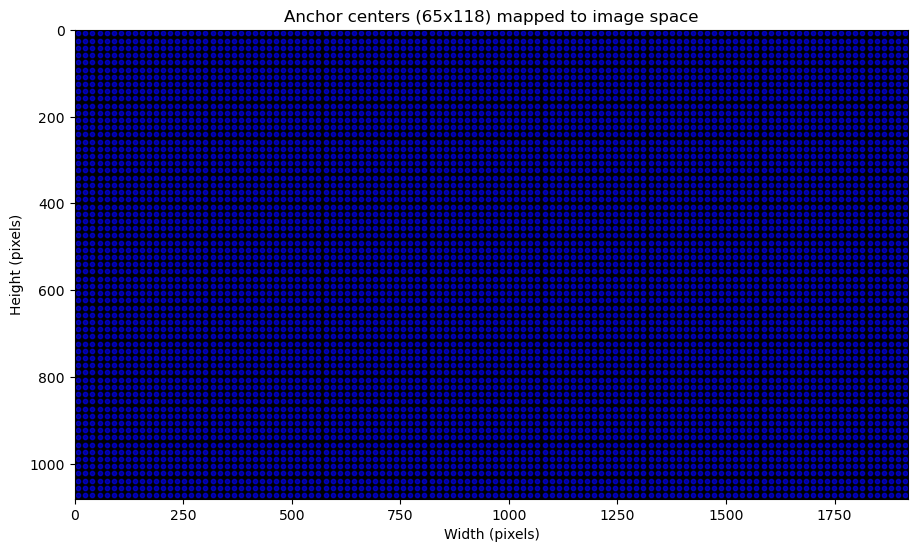

In [64]:
feature_extractor = InceptionFeatureExtractor()
feature_extractor.eval() 
out_dummy_img = feature_extractor(dummy_img)
print(f"Output shape: {out_dummy_img.shape}")
print(f"Number of channels: {out_dummy_img.shape[1]}")
print(f"Spatial dimensions: {out_dummy_img.shape[2]}x{out_dummy_img.shape[3]}")
feature_map_height = out_dummy_img.shape[2]
feature_map_width = out_dummy_img.shape[3]
original_height, original_width = dummy_img.shape[2], dummy_img.shape[3]
downsampling_factor_h = original_height / feature_map_height 
downsampling_factor_w = original_width / feature_map_width
scales = [8, 16, 32]
aspect_ratios = [0.5, 1.0, 2.0]


base_anchors = generate_base_anchors(scales, aspect_ratios, downsampling_factor_h, downsampling_factor_w)
anchors = generate_anchor_boxes(
    (feature_map_height, feature_map_width),
    base_anchors,
    downsampling_factor_h,
    downsampling_factor_w
)

print(f"# anchor boxes: {len(anchors)}")
print(f"anchor box shape: {anchors.shape}")
visualize_anchor_centers(dummy_img, (feature_map_height, feature_map_width), downsampling_factor_h, downsampling_factor_w)

## Testing anchor centers for highest resolution features (layer 5d)

In [65]:
class InceptionFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        model = inception_v3(weights=Inception_V3_Weights.DEFAULT, transform_input=True)
        self.feature_extractor = nn.Sequential(
            model.Conv2d_1a_3x3,
            model.Conv2d_2a_3x3,
            model.Conv2d_2b_3x3,
            model.maxpool1,
            model.Conv2d_3b_1x1,
            model.Conv2d_4a_3x3,
            model.maxpool2,
            model.Mixed_5b,
            model.Mixed_5c,
            model.Mixed_5d,
            # model.Mixed_6a,
            # model.Mixed_6b,
            # model.Mixed_6c,
            # model.Mixed_6d,
            # model.Mixed_6e,
            # model.Mixed_7a, 
            # model.Mixed_7b, 
            # model.Mixed_7c
        )
        
    def forward(self, x):
        return self.feature_extractor(x)
    


Output shape: torch.Size([1, 288, 132, 237])
Number of channels: 288
Spatial dimensions: 132x237
# anchor boxes: 281556
anchor box shape: (281556, 4)


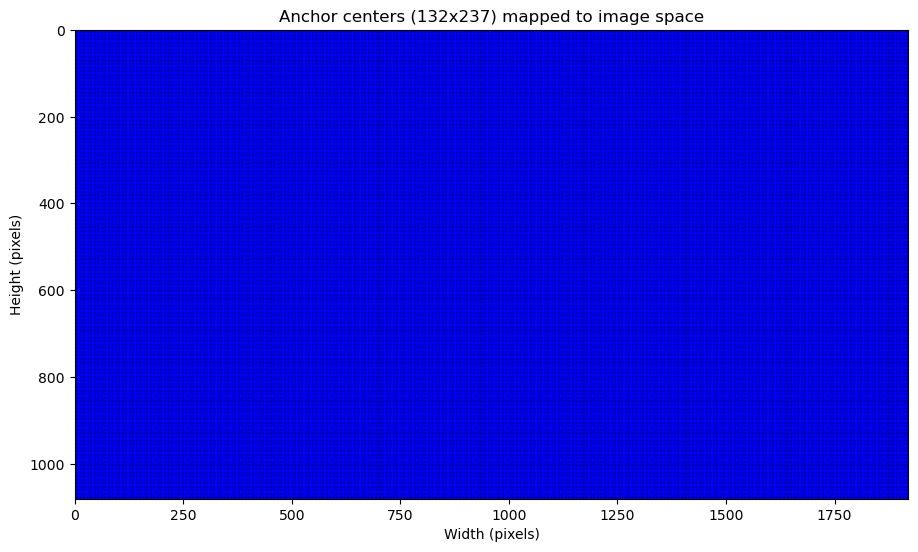

In [66]:
feature_extractor = InceptionFeatureExtractor()
feature_extractor.eval() 
out_dummy_img = feature_extractor(dummy_img)
print(f"Output shape: {out_dummy_img.shape}")
print(f"Number of channels: {out_dummy_img.shape[1]}")
print(f"Spatial dimensions: {out_dummy_img.shape[2]}x{out_dummy_img.shape[3]}")
feature_map_height = out_dummy_img.shape[2]
feature_map_width = out_dummy_img.shape[3]
original_height, original_width = dummy_img.shape[2], dummy_img.shape[3]
downsampling_factor_h = original_height / feature_map_height 
downsampling_factor_w = original_width / feature_map_width
scales = [8, 16, 32]
aspect_ratios = [0.5, 1.0, 2.0]


base_anchors = generate_base_anchors(scales, aspect_ratios, downsampling_factor_h, downsampling_factor_w)
anchors = generate_anchor_boxes(
    (feature_map_height, feature_map_width),
    base_anchors,
    downsampling_factor_h,
    downsampling_factor_w
)

print(f"# anchor boxes: {len(anchors)}")
print(f"anchor box shape: {anchors.shape}")
visualize_anchor_centers(dummy_img, (feature_map_height, feature_map_width), downsampling_factor_h, downsampling_factor_w)

# Visualizing anchor boxes on images

In [67]:
class InceptionFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        model = inception_v3(weights=Inception_V3_Weights.DEFAULT, transform_input=True)
        self.feature_extractor = nn.Sequential(
            model.Conv2d_1a_3x3,
            model.Conv2d_2a_3x3,
            model.Conv2d_2b_3x3,
            model.maxpool1,
            model.Conv2d_3b_1x1,
            model.Conv2d_4a_3x3,
            model.maxpool2,
            model.Mixed_5b,
            model.Mixed_5c,
            model.Mixed_5d,
            model.Mixed_6a,
            model.Mixed_6b,
            model.Mixed_6c,
            model.Mixed_6d,
            model.Mixed_6e,
            model.Mixed_7a, 
            model.Mixed_7b, 
            model.Mixed_7c
        )
        
    def forward(self, x):
        return self.feature_extractor(x)
    
feature_extractor = InceptionFeatureExtractor()
feature_extractor.eval() 
out_dummy_img = feature_extractor(dummy_img)
print(f"Output shape: {out_dummy_img.shape}")
print(f"Number of channels: {out_dummy_img.shape[1]}")
print(f"Spatial dimensions: {out_dummy_img.shape[2]}x{out_dummy_img.shape[3]}")




Output shape: torch.Size([1, 2048, 32, 58])
Number of channels: 2048
Spatial dimensions: 32x58


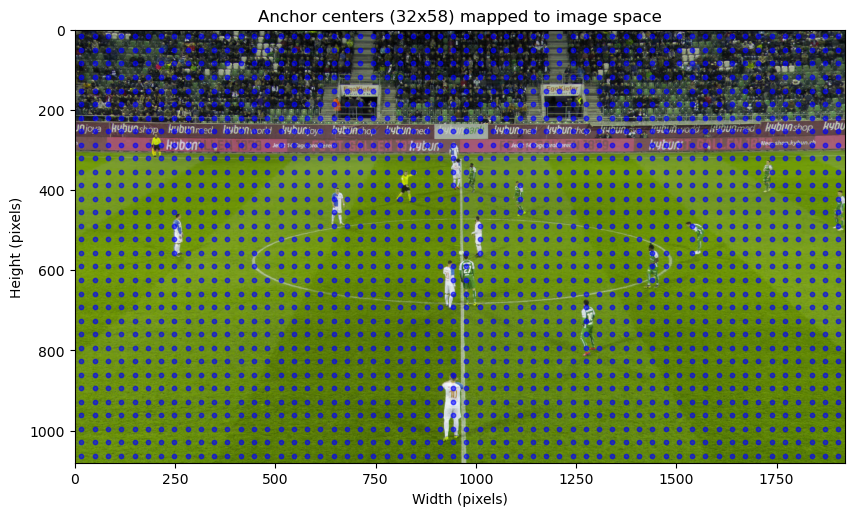

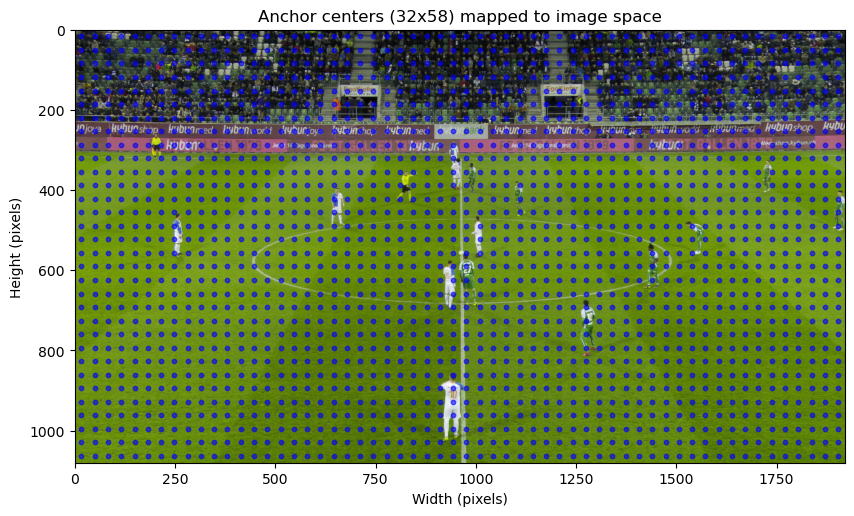

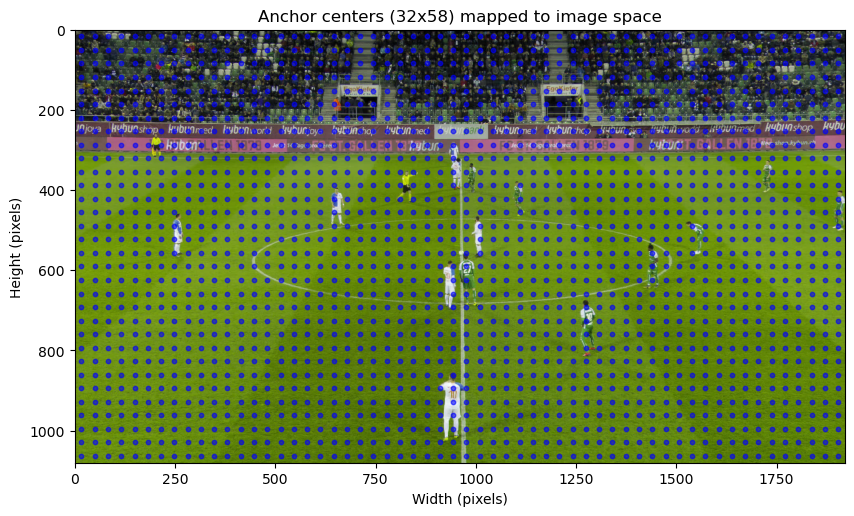

In [68]:

def visualize_anchors_on_sample_images(feature_extractor, image_dir='../soccernet_data/tracking/train/SNMOT-060/img1'):
    if not os.path.exists(image_dir):
        print(f"Directory {image_dir} does not exist.")
        return
    
    image_files = sorted(glob.glob(os.path.join(image_dir, '*.jpg')))
    sample_images = image_files[:3]
    
    image_net_mean = [0.485, 0.456, 0.406]
    image_net_std = [0.229, 0.224, 0.225]
    
    transform = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=image_net_mean, std=image_net_std)
    ])
    
    for img_path in sample_images:
        img = Image.open(img_path).convert('RGB')
        img_w, img_h = img.size
        img_tensor = transform(img).unsqueeze(0)
        
        feature_extractor.eval()
        with torch.no_grad():
            features = feature_extractor(img_tensor)
        
        feature_map_height = features.shape[2]
        feature_map_width = features.shape[3]
        
        downsampling_factor_h = img_h / feature_map_height
        downsampling_factor_w = img_w / feature_map_width
        
        scales = [8, 16, 32]
        aspect_ratios = [0.5, 1.0, 2.0]
        base_anchors = generate_base_anchors(scales, aspect_ratios, downsampling_factor_h, downsampling_factor_w)
        anchors = generate_anchor_boxes(
            (feature_map_height, feature_map_width),
            base_anchors,
            downsampling_factor_h,
            downsampling_factor_w
        )
        
        plt.figure(figsize=(10, 5.625))
        ax = plt.gca()
        ax.imshow(np.array(img), extent=(0, img_w, img_h, 0))
        
        center_y = np.arange(0, feature_map_height) * downsampling_factor_h + downsampling_factor_h / 2.0
        center_x = np.arange(0, feature_map_width) * downsampling_factor_w + downsampling_factor_w / 2.0
        center_x, center_y = np.meshgrid(center_x, center_y)
        
        ax.scatter(center_x, center_y, c='b', s=10, alpha=0.6, marker='o')
        ax.set_title(f'Anchor centers ({feature_map_height}x{feature_map_width}) mapped to image space')
        ax.set_xlim(0, img_w)
        ax.set_ylim(img_h, 0)
        ax.set_xlabel("Width (pixels)")
        ax.set_ylabel("Height (pixels)")
        ax.set_aspect('equal', adjustable='box')
        
        plt.show()
        
    

visualize_anchors_on_sample_images(feature_extractor)




# Visualizing anchor centers with features

In [71]:
def visualize_anchors_on_features(feature_extractor, image_dir = '../soccernet_data/tracking/train/SNMOT-060/img1'):
    if not os.path.exists(image_dir):
        print(f"Directory {image_dir} does not exist.")
        return

    image_files = sorted(glob.glob(os.path.join(image_dir, '*.jpg')))
    sample_images = image_files[:3]

    image_net_mean = [0.485, 0.456, 0.406]
    image_net_std=[0.229, 0.224, 0.225]

    transform = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=image_net_mean, std=image_net_std)
    ])

    for img_path in sample_images:
        
        img = Image.open(img_path).convert('RGB')
        img_w, img_h = img.size
        
        img_tensor = transform(img).unsqueeze(0)

        
        feature_extractor.eval()
        with torch.no_grad():
            features = feature_extractor(img_tensor)

        feature_map_height = features.shape[2]
        feature_map_width = features.shape[3]
        downsampling_factor_h = img_h / feature_map_height
        downsampling_factor_w = img_w / feature_map_width

        
        center_y_orig = np.arange(0.5, feature_map_height + 0.5) * downsampling_factor_h
        center_x_orig = np.arange(0.5, feature_map_width + 0.5) * downsampling_factor_w
        center_x_orig, center_y_orig = np.meshgrid(center_x_orig, center_y_orig)

        
        grid_center_y = np.arange(0, feature_map_height) + 0.5
        grid_center_x = np.arange(0, feature_map_width) + 0.5
        grid_center_x, grid_center_y = np.meshgrid(grid_center_x, grid_center_y)
            
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    
        ax1.imshow(img)
    
        ax1.scatter(center_x_orig, center_y_orig, c='blue', s=10, alpha=0.5, marker='+')
        ax1.set_title("Original Image with Anchor Centers")
        ax1.set_xlim(0, img_w)
        ax1.set_ylim(img_h, 0)
        ax1.axis('on')
        ax1.set_xlabel("Width (pixels)")
        ax1.set_ylabel("Height (pixels)")

        feature_map_sum = features[0].sum(dim=0).cpu().numpy()
        im = ax2.imshow(feature_map_sum, cmap='viridis', extent=(0, feature_map_width, feature_map_height, 0))
        ax2.scatter(grid_center_x, grid_center_y, c='red', s=10, alpha=0.5, marker='+')
        ax2.set_title(f"Feature Map Sum ({features.shape[1]} channels) w/ Anchors")
        ax2.set_xlim(0, feature_map_width)
        ax2.set_ylim(feature_map_height, 0) 
        ax2.axis('on') 
        ax2.set_xlabel("Width (feature units)")
        ax2.set_ylabel("Height (feature units)")

        plt.figtext(0.5, 0.01,
                    f'Downsampling factors: W={downsampling_factor_w:.1f}, H={downsampling_factor_h:.1f}',
                    ha='center', fontsize=10)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


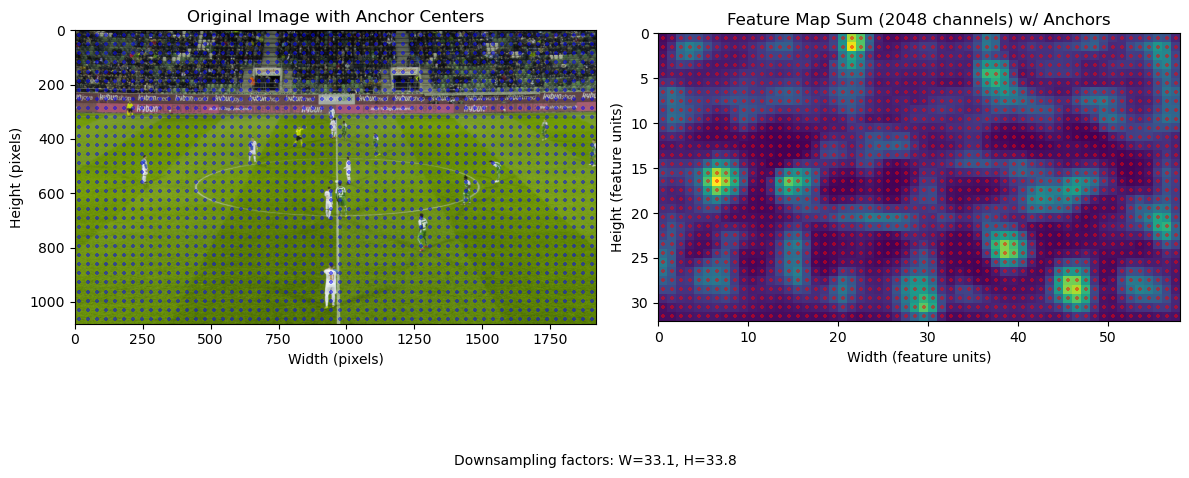

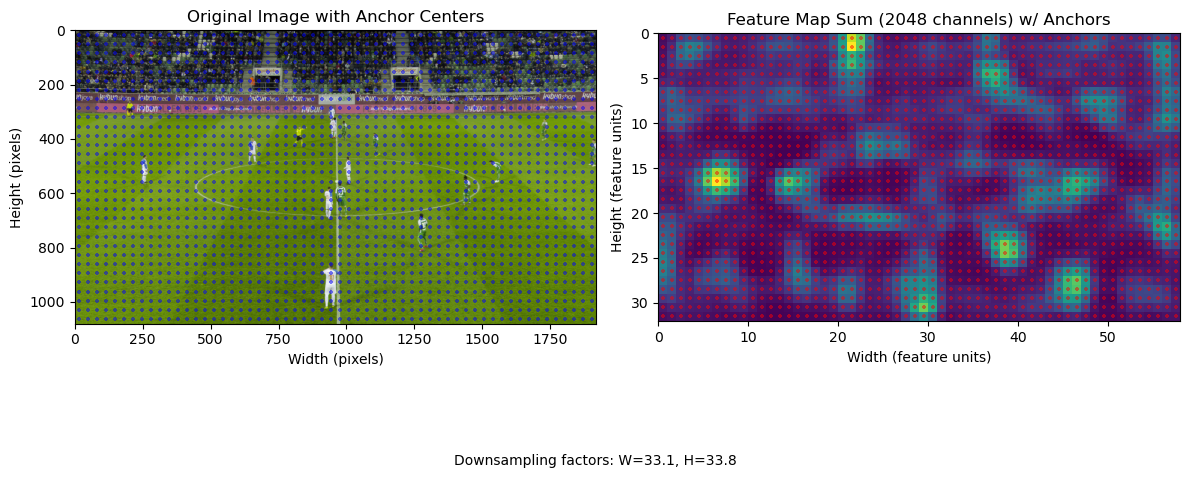

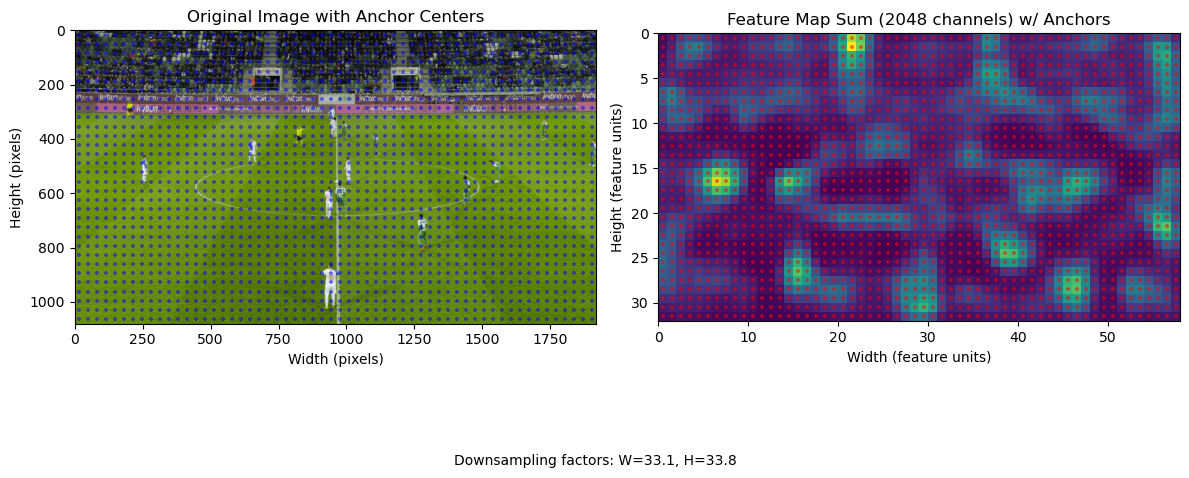

In [72]:
visualize_anchors_on_features(feature_extractor, image_dir='../soccernet_data/tracking/train/SNMOT-060/img1')